In [68]:
! pip install optuna

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [126]:
df = pd.read_csv('processed_bank_marketing.csv')

In [127]:
# Extract features, labels, and protected group
X = df.drop(columns=["deposit"])
y = df["deposit"].values
protected_attr = df["marital"].values  # 0 = single, 1 = married, 2 = divorced

In [128]:
# Define fairness metric (max-min demographic parity across marital groups)
def demographic_parity_diff(y_pred, protected_group):
    group_probs = [
        y_pred[protected_group == g].mean()
        for g in np.unique(protected_group)
    ]
    return max(group_probs) - min(group_probs)

#  Objective function for Optuna
def objective(trial):
    C = trial.suggest_float("C", 0.01, 10, log=True)
    clf = LogisticRegression(C=C, max_iter=5000, solver='liblinear')

    X_train, X_test, y_train, y_test, m_train, m_test = train_test_split(
        X, y, protected_attr, test_size=0.2, random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    fairness = demographic_parity_diff(y_pred, m_test)

    return acc, -fairness  # maximize accuracy, minimize disparity

In [129]:
#  Run the multi-objective optimization
study = optuna.create_study(
    directions=["maximize", "maximize"]
)
study.optimize(objective, n_trials=500)

[I 2025-05-16 19:00:00,232] A new study created in memory with name: no-name-592751cc-daf0-4bd2-a0b0-516963391b46
[I 2025-05-16 19:00:00,311] Trial 0 finished with values: [0.7899686520376176, -0.13607236575815318] and parameters: {'C': 0.1808736524738411}.
[I 2025-05-16 19:00:00,369] Trial 1 finished with values: [0.7890729959695477, -0.13607236575815318] and parameters: {'C': 0.014740364474105422}.
[I 2025-05-16 19:00:00,428] Trial 2 finished with values: [0.7890729959695477, -0.1346272790529509] and parameters: {'C': 0.40034245072621055}.
[I 2025-05-16 19:00:00,487] Trial 3 finished with values: [0.7890729959695477, -0.1411944079351291] and parameters: {'C': 0.7885148015726727}.
[I 2025-05-16 19:00:00,539] Trial 4 finished with values: [0.7899686520376176, -0.1402791484562244] and parameters: {'C': 0.03289377677469589}.
[I 2025-05-16 19:00:00,603] Trial 5 finished with values: [0.7904164800716524, -0.13528558369678423] and parameters: {'C': 1.3335188979179577}.
[I 2025-05-16 19:00:0

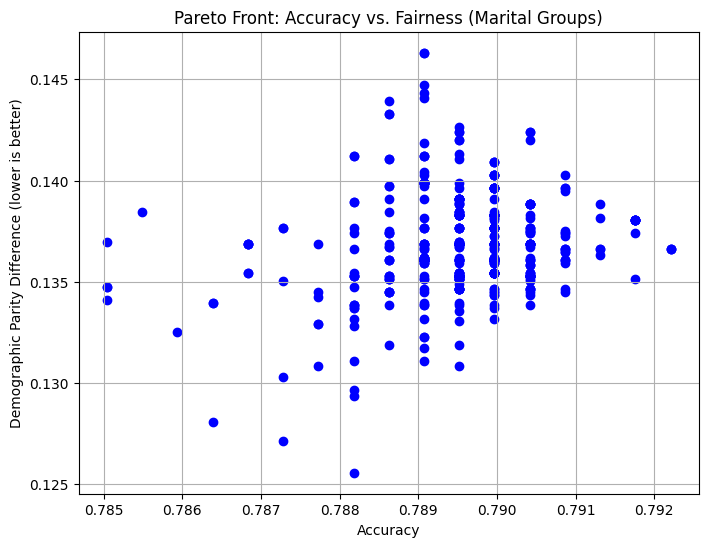

In [130]:
# Plot Pareto frontier
accs = [t.values[0] for t in study.trials]
fairness_scores = [-t.values[1] for t in study.trials]

plt.figure(figsize=(8, 6))
plt.scatter(accs, fairness_scores, c="blue")
plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Pareto Front: Accuracy vs. Fairness (Marital Groups)")
plt.grid(True)
plt.show()


In [131]:
# Print Top 10 Pareto-optimal Trials (low disparity, then high accuracy)
results = [
    {
        "accuracy": t.values[0],
        "fairness": -t.values[1],  # flip sign back
        "params": t.params
    }
    for t in study.trials
]

def is_dominated(r1, r2):
    return (r2["accuracy"] >= r1["accuracy"] and r2["fairness"] <= r1["fairness"]
            and (r2["accuracy"] > r1["accuracy"] or r2["fairness"] < r1["fairness"]))

# Find non-dominated (Pareto-optimal) points
pareto_points = []
for r1 in results:
    if not any(is_dominated(r1, r2) for r2 in results if r2 != r1):
        pareto_points.append(r1)

# Sort by fairness for cleaner plotting
pareto_points = sorted(pareto_points, key=lambda x: x["fairness"])


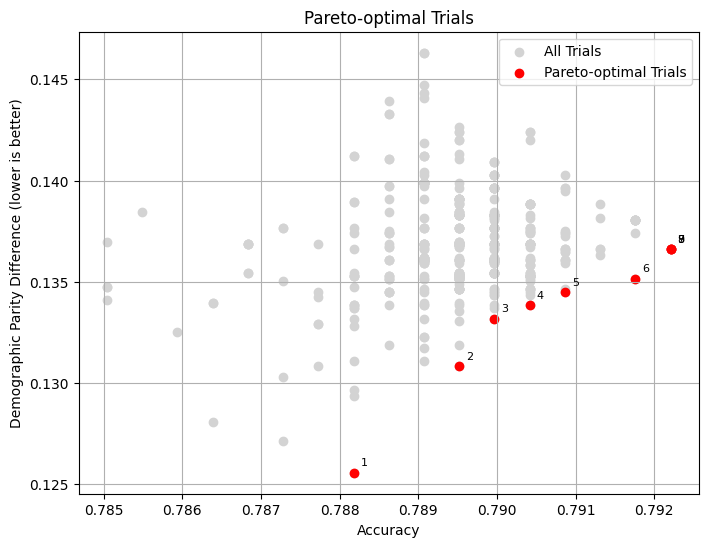

In [133]:
# Visualization
all_acc = [r["accuracy"] for r in results]
all_fair = [r["fairness"] for r in results]

pareto_acc = [r["accuracy"] for r in pareto_points]
pareto_fair = [r["fairness"] for r in pareto_points]

plt.figure(figsize=(8, 6))
plt.scatter(all_acc, all_fair, color="lightgray", label="All Trials")
plt.scatter(pareto_acc, pareto_fair, color="red", label="Pareto-optimal Trials")

# Add annotations
for i, (x, y) in enumerate(zip(pareto_acc, pareto_fair)):
    plt.annotate(f"{i+1}", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=8)

plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Pareto-optimal Trials")
plt.legend()
plt.grid(True)
plt.show()


In [134]:
# Print Pareto-optimal trials
print("Pareto-optimal Trials:\n")
for i, r in enumerate(pareto_points):
    print(f"{i+1}  Accuracy:  {r['accuracy']:.4f}     Fairness:  {r['fairness']:.4f}  Params:    {r['params']}")

Pareto-optimal Trials:

1  Accuracy:  0.7882     Fairness:  0.1256  Params:    {'C': 1.7008021695866808}
2  Accuracy:  0.7895     Fairness:  0.1308  Params:    {'C': 0.6889367620281636}
3  Accuracy:  0.7900     Fairness:  0.1332  Params:    {'C': 9.362048338011848}
4  Accuracy:  0.7904     Fairness:  0.1338  Params:    {'C': 0.2774540519206283}
5  Accuracy:  0.7909     Fairness:  0.1345  Params:    {'C': 8.34431753095483}
6  Accuracy:  0.7918     Fairness:  0.1352  Params:    {'C': 0.06381656061873184}
7  Accuracy:  0.7922     Fairness:  0.1366  Params:    {'C': 0.059729469545183066}
8  Accuracy:  0.7922     Fairness:  0.1366  Params:    {'C': 0.058856928331692905}
9  Accuracy:  0.7922     Fairness:  0.1366  Params:    {'C': 0.06225026047297803}


In [135]:
import csv
with open('pareto_results.csv', 'a', newline='') as f:
    writer = csv.writer(f)
    for i, point in enumerate(pareto_points):
        writer.writerow([
            'Optuna', 'LR',
            point["accuracy"],
            point["fairness"],
            str(point["params"])  # assuming pareto_points contains params
        ])

# Random Forest as Model

In [79]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
import matplotlib.pyplot as plt

In [80]:
# Same as before, in lr
df = pd.read_csv("processed_bank_marketing.csv")
df = df.dropna()
X = df.drop(columns=["deposit"])
y = df["deposit"].values
protected_attr = df["marital"].values  # 0, 1, 2 → single, married, divorced
X = pd.get_dummies(X, drop_first=True)

In [81]:
# Define fairness metric (max-min demographic parity across marital groups)
def demographic_parity_diff(y_pred, protected_group):
    group_probs = [
        y_pred[protected_group == g].mean()
        for g in np.unique(protected_group)
    ]
    return max(group_probs) - min(group_probs)

# Objective function for Optuna using Random Forest
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)

    # Random Forest Classifier
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, m_train, m_test = train_test_split(
        X, y, protected_attr, test_size=0.2, random_state=42
    )

    # Fit the model
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Calculate accuracy and fairness
    acc = accuracy_score(y_test, y_pred)
    fairness = demographic_parity_diff(y_pred, m_test)

    # Return accuracy and negative fairness (to minimize disparity)
    return acc, -fairness  # maximize accuracy, minimize disparity


In [82]:
#  Run the optimization with Random Forest
study = optuna.create_study(
    directions=["maximize", "maximize"]
)
study.optimize(objective, n_trials=50)

[I 2025-05-16 18:30:23,754] A new study created in memory with name: no-name-430a2d0b-a3d1-418c-acab-ad1a8c2afdba
[I 2025-05-16 18:30:24,426] Trial 0 finished with values: [0.8266905508284819, -0.12211835385182118] and parameters: {'n_estimators': 123, 'max_depth': 9, 'min_samples_split': 5}.
[I 2025-05-16 18:30:24,980] Trial 1 finished with values: [0.800268696820421, -0.07653388392918048] and parameters: {'n_estimators': 166, 'max_depth': 5, 'min_samples_split': 6}.
[I 2025-05-16 18:30:25,774] Trial 2 finished with values: [0.8204209583519928, -0.12394887280963057] and parameters: {'n_estimators': 152, 'max_depth': 9, 'min_samples_split': 7}.
[I 2025-05-16 18:30:26,105] Trial 3 finished with values: [0.8047469771607703, -0.09557696593188192] and parameters: {'n_estimators': 77, 'max_depth': 6, 'min_samples_split': 8}.
[I 2025-05-16 18:30:26,698] Trial 4 finished with values: [0.8007165248544559, -0.07351523310124025] and parameters: {'n_estimators': 163, 'max_depth': 5, 'min_samples_

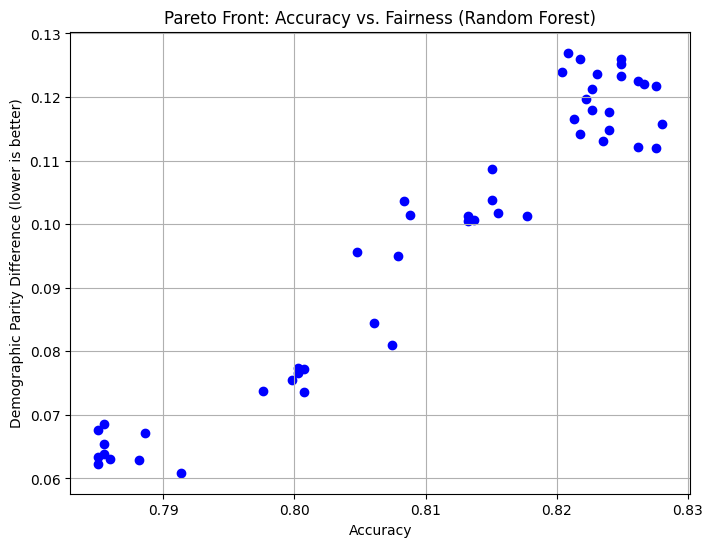

In [83]:
# Plot explored points
accs = [t.values[0] for t in study.trials]
fairness_scores = [-t.values[1] for t in study.trials]

plt.figure(figsize=(8, 6))
plt.scatter(accs, fairness_scores, c="blue")
plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Pareto Front: Accuracy vs. Fairness (Random Forest)")
plt.grid(True)
plt.show()

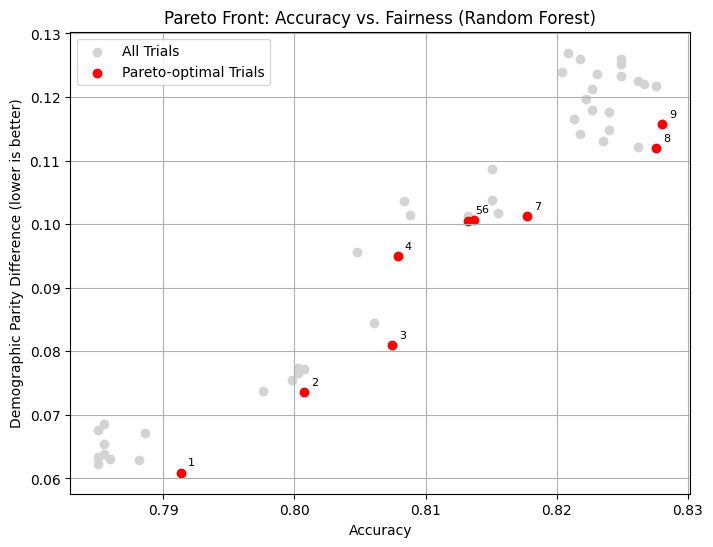

In [84]:
# Visualize Pareto-optimal trials

# Gather accuracy and fairness (flipping the fairness sign)
results = [
    {
        "accuracy": t.values[0],
        "fairness": -t.values[1],  # flip sign back to get actual fairness value
        "params": t.params
    }
    for t in study.trials
]

# Function to determine if r1 is dominated by r2
def is_dominated(r1, r2):
    return (r2["accuracy"] >= r1["accuracy"] and r2["fairness"] <= r1["fairness"] and
            (r2["accuracy"] > r1["accuracy"] or r2["fairness"] < r1["fairness"]))

# Extract Pareto-optimal (non-dominated) trials
pareto_trials = []
for r1 in results:
    if not any(is_dominated(r1, r2) for r2 in results if r2 != r1):
        pareto_trials.append(r1)

# Sort Pareto front by fairness for nicer plots (optional)
pareto_trials = sorted(pareto_trials, key=lambda x: x["fairness"])

# Plot all trials and highlight the Pareto-optimal ones
accs = [r["accuracy"] for r in results]
fairness_scores = [r["fairness"] for r in results]

pareto_accs = [r["accuracy"] for r in pareto_trials]
pareto_fairness = [r["fairness"] for r in pareto_trials]

plt.figure(figsize=(8, 6))
plt.scatter(accs, fairness_scores, c="lightgray", label="All Trials")
plt.scatter(pareto_accs, pareto_fairness, c="red", label="Pareto-optimal Trials")

# Annotate points
for i, (x, y) in enumerate(zip(pareto_accs, pareto_fairness)):
    plt.annotate(f"{i+1}", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=8)

plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Pareto Front: Accuracy vs. Fairness (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()


In [85]:
# Show top 10 Pareto-optimal trials in text
print("Top Pareto-optimal Trials:\n")
for i, r in enumerate(pareto_trials[:10]):
    print(f"{i+1}. Accuracy: {r['accuracy']:.4f}, Fairness: {r['fairness']:.4f}, Params: {r['params']}")

Top Pareto-optimal Trials:

1. Accuracy: 0.7913, Fairness: 0.0609, Params: {'n_estimators': 82, 'max_depth': 4, 'min_samples_split': 3}
2. Accuracy: 0.8007, Fairness: 0.0735, Params: {'n_estimators': 163, 'max_depth': 5, 'min_samples_split': 9}
3. Accuracy: 0.8074, Fairness: 0.0810, Params: {'n_estimators': 179, 'max_depth': 6, 'min_samples_split': 9}
4. Accuracy: 0.8079, Fairness: 0.0949, Params: {'n_estimators': 96, 'max_depth': 6, 'min_samples_split': 5}
5. Accuracy: 0.8133, Fairness: 0.1006, Params: {'n_estimators': 152, 'max_depth': 7, 'min_samples_split': 7}
6. Accuracy: 0.8137, Fairness: 0.1007, Params: {'n_estimators': 86, 'max_depth': 7, 'min_samples_split': 6}
7. Accuracy: 0.8177, Fairness: 0.1012, Params: {'n_estimators': 138, 'max_depth': 7, 'min_samples_split': 4}
8. Accuracy: 0.8276, Fairness: 0.1120, Params: {'n_estimators': 82, 'max_depth': 8, 'min_samples_split': 4}
9. Accuracy: 0.8280, Fairness: 0.1157, Params: {'n_estimators': 98, 'max_depth': 8, 'min_samples_split':

In [86]:
import csv
with open('pareto_results.csv', 'a', newline='') as f:
    writer = csv.writer(f)
    for trial in pareto_trials:
        writer.writerow([
            'Optuna', 'RF',
            trial["accuracy"],
            trial["fairness"],
            str(trial["params"])
        ])

# Nueral Network as Model

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import optuna
import matplotlib.pyplot as plt
import torch.utils.data as data

In [88]:
df = pd.read_csv("processed_bank_marketing.csv")
df = df.dropna()
X = df.drop(columns=["deposit"])
y = df["deposit"].values
protected_attr = df["marital"].values  # 0, 1, 2 → single, married, divorced
X = pd.get_dummies(X, drop_first=True)

# Preprocess the data (standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

#  Split the data into training and testing sets
X_train, X_test, y_train, y_test, m_train, m_test = train_test_split(
    X_tensor, y_tensor, protected_attr, test_size=0.2, random_state=42
)

# Use DataLoader for batching
train_data = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)

In [89]:
# Define fairness metric (max-min demographic parity across marital groups)
def demographic_parity_diff(y_pred, protected_group):
    group_probs = [
        y_pred[protected_group == g].mean()
        for g in np.unique(protected_group)
    ]
    return max(group_probs) - min(group_probs)

# Define a PyTorch neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_units, layers):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_units))
        self.layers.append(nn.ReLU())
        
        for _ in range(layers - 1):
            self.layers.append(nn.Linear(hidden_units, hidden_units))
            self.layers.append(nn.ReLU())
        
        self.output_layer = nn.Linear(hidden_units, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.sigmoid(self.output_layer(x))

# Objective function for Optuna using Neural Network
def objective(trial):
    # Hyperparameters for the model
    layers = trial.suggest_int("layers", 1, 4)
    units = trial.suggest_int("units", 32, 128)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    # Initialize the model
    model = NeuralNetwork(X_train.shape[1], units, layers)
    
    # Define the loss and optimizer
    criterion = nn.BCELoss()  # Binary cross entropy loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model with batching
    epochs = 100  # Increased number of epochs
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_class = (y_pred > 0.5).float()  # Classify based on 0.5 threshold

    # Calculate accuracy and fairness
    acc = accuracy_score(y_test.numpy(), y_pred_class.numpy())
    fairness = demographic_parity_diff(y_pred_class.numpy(), m_test)

    # Return accuracy and negative fairness (to minimize disparity)
    return acc, -fairness  # maximize accuracy, minimize disparity

In [90]:
# Run the optimization with PyTorch Neural Network
study = optuna.create_study(
    directions=["maximize", "maximize"]
)
study.optimize(objective, n_trials=50)

[I 2025-05-16 18:30:48,527] A new study created in memory with name: no-name-9521d2fd-cfb7-4745-b454-87a5e0d8c337
[I 2025-05-16 18:30:55,287] Trial 0 finished with values: [0.8029556650246306, -0.1502981185913086] and parameters: {'layers': 1, 'units': 39, 'learning_rate': 6.67209687606622e-05}.
[I 2025-05-16 18:31:05,023] Trial 1 finished with values: [0.7971339005821765, -0.10248178243637085] and parameters: {'layers': 4, 'units': 50, 'learning_rate': 0.00031804309822914856}.
[I 2025-05-16 18:31:12,472] Trial 2 finished with values: [0.8074339453649798, -0.1370183229446411] and parameters: {'layers': 2, 'units': 35, 'learning_rate': 0.037616594093130014}.
[I 2025-05-16 18:31:24,465] Trial 3 finished with values: [0.7953425884460367, -0.13732415437698364] and parameters: {'layers': 3, 'units': 87, 'learning_rate': 1.4650697543352737e-05}.
[I 2025-05-16 18:31:32,324] Trial 4 finished with values: [0.8087774294670846, -0.12536215782165527] and parameters: {'layers': 1, 'units': 53, 'lea

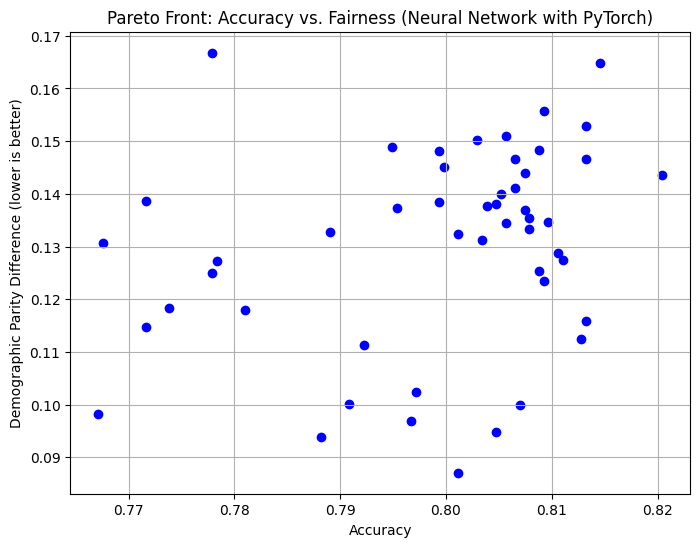

In [91]:
# Plot Pareto frontier
accs = [t.values[0] for t in study.trials]
fairness_scores = [-t.values[1] for t in study.trials]

plt.figure(figsize=(8, 6))
plt.scatter(accs, fairness_scores, c="blue")
plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Pareto Front: Accuracy vs. Fairness (Neural Network with PyTorch)")
plt.grid(True)
plt.show()

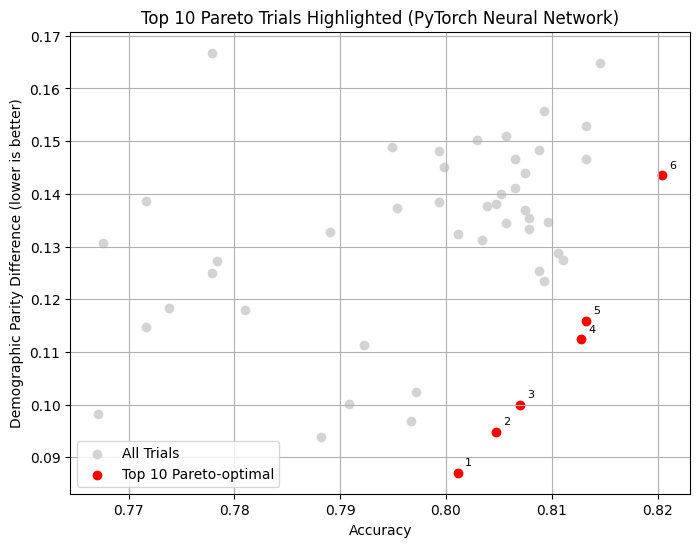

In [92]:
results = [
    {
        "accuracy": t.values[0],
        "fairness": -t.values[1],  # flip sign back to actual DPD
        "params": t.params
    }
    for t in study.trials
]

# Define dominance logic
def is_dominated(r1, r2):
    return (r2["accuracy"] >= r1["accuracy"] and r2["fairness"] <= r1["fairness"] and
            (r2["accuracy"] > r1["accuracy"] or r2["fairness"] < r1["fairness"]))

# Compute non-dominated (Pareto-optimal) trials
pareto_trials = []
for r1 in results:
    if not any(is_dominated(r1, r2) for r2 in results if r2 != r1):
        pareto_trials.append(r1)

# Sort Pareto-optimal trials for visualization (optional)
pareto_trials_sorted = sorted(pareto_trials, key=lambda x: x["fairness"])

# Top 10 Pareto-optimal trials (by fairness for readability)
top10 = pareto_trials_sorted[:10]
top10_acc = [r["accuracy"] for r in top10]
top10_fair = [r["fairness"] for r in top10]

# Visualize all trials and highlight top 10 Pareto-optimal ones
accs = [r["accuracy"] for r in results]
fairness_scores = [r["fairness"] for r in results]

plt.figure(figsize=(8, 6))
plt.scatter(accs, fairness_scores, color="lightgray", label="All Trials")
plt.scatter(top10_acc, top10_fair, color="red", label="Top 10 Pareto-optimal")

# Add annotations
for i, (x, y) in enumerate(zip(top10_acc, top10_fair)):
    plt.annotate(f"{i+1}", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=8)

plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Top 10 Pareto Trials Highlighted (PyTorch Neural Network)")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
for i, r in enumerate(top10):
    print(f"{i+1}. Accuracy: {r['accuracy']:.4f}, Fairness: {r['fairness']:.4f}, Params: {r['params']}")

1. Accuracy: 0.8012, Fairness: 0.0871, Params: {'layers': 1, 'units': 53, 'learning_rate': 0.09988429365244332}
2. Accuracy: 0.8047, Fairness: 0.0949, Params: {'layers': 2, 'units': 85, 'learning_rate': 0.0004699624436322648}
3. Accuracy: 0.8070, Fairness: 0.1000, Params: {'layers': 2, 'units': 96, 'learning_rate': 0.01861933340895377}
4. Accuracy: 0.8128, Fairness: 0.1124, Params: {'layers': 4, 'units': 32, 'learning_rate': 0.0005339301347565863}
5. Accuracy: 0.8133, Fairness: 0.1159, Params: {'layers': 1, 'units': 59, 'learning_rate': 0.06134037353187547}
6. Accuracy: 0.8204, Fairness: 0.1435, Params: {'layers': 2, 'units': 74, 'learning_rate': 0.08033581470721425}


In [94]:
import csv
with open('pareto_results.csv', 'a', newline='') as f:
    writer = csv.writer(f)
    for trial in pareto_trials_sorted[:10]:  
        writer.writerow([
            'Optuna', 'NN',
            trial["accuracy"],
            trial["fairness"],
            str(trial["params"])
        ])